In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pvanalysis import PVAnalysis
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
'-------- INPUTS --------'
fitsfile = './testfits/test.fits'
outname = 'pvanalysis'  # file name header for outputs
incl = 48.  # deg
vsys = 6.4  # km/s
dist = 140.  # pc
rms = 1.7e-3  # Jy/beam
thr = 5.  # rms
ridgemode = 'mean'  # 'mean' or 'gauss'
xlim = [-200, 0, 0, 200]  # au; [-outlim, -inlim, inlim, outlim]
vlim = np.array([-5, 0, 0, 5]) + vsys  # km/s
Mlim = [0, 10]  # M_sun; to exclude unreasonable points
xlim_plot = [200. / 20., 200.]  # au; [inlim, outlim]
vlim_plot = [6. / 20., 6.]  # km/s
use_velocity = True  # cuts along the velocity direction
use_position = True  # cuts along the positional direction
include_vsys = False  # vsys offset. False means vsys=0.
include_dp = True  # False means a single power
include_pin = False  # False means pin=0.5 (Keplerian).
show_pv = True  # figures will be made regardless of this option.
show_corner = True  # figures will be made regardless of this option.
minabserr = 0.1  # minimum absolute errorbar in the unit of bmaj or dv.
minrelerr = 0.01  # minimum relative errorbar.
'------------------------'

'------------------------'

In [120]:
impv = PVAnalysis(fitsfile, rms, vsys, dist, pa=None)
#print(impv.fitsdata.naxis, impv.fitsdata.data.shape, impv.fitsdata.beam)
#impv.fitsdata.beam_deconvolution(sigmacut=rms*3., highcut=1.) # highcut=5.
sigmacut=3.*rms
highcut=1

read_pvfits: No PA information is given.
read_pvfits: Convert frequency to velocity


In [121]:
from scipy.fft import fftshift
from scipy.fft import ifftn
from scipy.fft import fftn
from scipy.fft import fftfreq
# 1D Gaussian function
from pvanalysis.fitfuncs import gauss1d #(x,amp,mean,sig):

In [122]:
data = impv.fitsdata.data.copy()
if sigmacut:
    data[data < sigmacut] = 0.

# beam array
nv, nx = impv.fitsdata.nv, impv.fitsdata.nx
if impv.fitsdata.multibeam:
    beam = np.empty((nv,nx))
    for i in range(len(impv.fitsdata.beam)):
        bmaj, bmin, bpa, _, _ = impv.fitsdata.beam[i]
        if impv.fitsdata.pa != None:
            res_off = get_1dresolution(impv.fitsdata.pa, bmaj, bmin, bpa)
        else:
            res_off = bmaj
        beam[i, :] = gauss1d(impv.fitsdata.xaxis, 1., 0., res_off)
        beam[i, :] /= np.sum(beam[i, :]) # normalize
elif impv.fitsdata.res_off != None:
    _beam = gauss1d(impv.fitsdata.xaxis, 1., 0., impv.fitsdata.res_off)
    _beam /= np.sum(_beam) # normalize
    beam = np.tile(_beam, (nv,1))
else:
    print('ERROR\tbeam_deconvolution: angular resolution is not given correctly.')
    print('ERROR\tbeam_deconvolution: check the header of the input fits file.')

In [138]:
# check axis
if impv.fitsdata.naxis == 2:
    fftaxes=(1,)
    shape = (nv, nx)
elif impv.fitsdata.naxis == 3:
    beam = beam.reshape(1,nv,nx)
    fftaxes = (2,)
    shape = (1, nv, nx)
else:
    print('ERROR\tbeam_deconvolution: number of fits axes must be 2 or 3.')

# FFT
freq_x   = fftshift(fftfreq(nx, impv.fitsdata.delx))
freq_v   = fftshift(fftfreq(nv, impv.fitsdata.delv))
ffx, ffv = np.meshgrid(freq_x, freq_v)
ffx = ffx.reshape(shape)
beam_fft = fftshift(fftn(beam, axes=fftaxes), axes=fftaxes)
data_fft = fftshift(fftn(data, axes=fftaxes), axes=fftaxes)

In [139]:
# deconvolution
sigma_beam_fft = 1./(impv.fitsdata.res_off*np.pi)
#print(sigma_beam_fft)
d_deconv_fft = data_fft/beam_fft

if highcut != None:
    d_deconv_fft[np.abs(ffx) > sigma_beam_fft*highcut] = 0.+0.j # drop highfreq. components
d_deconv = np.abs(fftshift(ifftn(d_deconv_fft, axes=fftaxes), axes=fftaxes))

(1, 40, 401) (1, 40, 401)
16


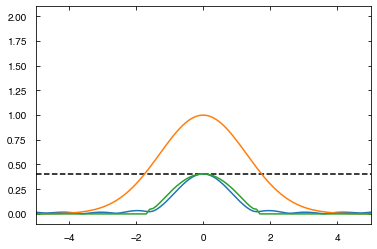

In [159]:
from scipy.signal import argrelmin, argrelmax
test_indx = nv//4+2
highcut   = 1.

d_1d = data[0,test_indx,:]
print(data.shape, data_fft.shape)
#d_fft_1d = fftshift(fftn(d_1d))
#print(d_1d)
d_fft_1d    = np.abs(data_fft)[0,test_indx,:]
beam_fft_1d = np.abs(beam_fft)[0,test_indx,:]
d_deconv_fft_1d = d_fft_1d/beam_fft_1d
#if highcut != None:
#    d_deconv_fft_1d[np.abs(freq_x) > sigma_beam_fft*highcut] = 0.
first_null = argrelmin(d_fft_1d[nx//2:])[0][0]
print(first_null)
d_deconv_fft_1d[ np.abs(freq_x) > freq_x[nx//2:][first_null]] = 0.

plt.plot(freq_x, d_fft_1d)
plt.plot(freq_x, beam_fft_1d)
plt.plot(freq_x, d_deconv_fft_1d)
plt.hlines(np.sum(d_1d), -5, 5, ls='--', color='k')
#print(np.sum(d_1d))
plt.xlim(-5,5)
plt.ylim(-0.1,2.1)
plt.show()